This notebook implements Conservative Q-Learning to solve a simple Maze 2D environment.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

from typing import Tuple, Optional

import numpy as np
from loguru import logger
import matplotlib.pyplot as plt
from IPython.display import Image
from src.utils import (
    get_device,
    set_seed,
    eval_policy,
    demo_policy,
    plot_returns,
    save_frames_as_gif,
    return_range
)
from tqdm import tqdm
import einops
import os
import copy

from src.d4rl_dataset import D4RLSampler

plt.ion()

/home/hice1/ibaali3/.conda/envs/cs8803drl_hw2/lib/python3.10/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists


Offline RL algorithms aim at training an optimal policy from pre-collected data. As such, we need to import this training data that will be used with IQL.
For that purpose, we start by importing D4RL, a library that contains training data obtained by running policy of different levels on a few environments. More information about D4RL can be found [in the original paper.](https://arxiv.org/abs/2004.07219).

In [2]:
import gym
import d4rl

/home/hice1/ibaali3/.conda/envs/cs8803drl_hw2/lib/python3.10/site-packages/Cython/Distutils/old_build_ext.py:15: DeprecationWarning: dep_util is Deprecated. Use functions from setuptools instead.
  from distutils.dep_util import newer, newer_group
<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
No module named 'flow'
/home/hice1/ibaali3/.conda/envs/cs8803drl_hw2/lib/python3.10/site-packages/glfw/__init__.py:914: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
No module named 'carla'
pybullet build time: Nov 28 2023 23:45:17


Then, we create the environment. As an example, we use the Maze2D U-shaped environment, for which the objective is to move a ball to explore a maze using two forces, lateral and longitudinal. The action space is continuous and has dimension 2. For reproducibility, we also set the seed to a fixed value.

In [3]:
SEED: int = 42
ENVIRONMENT_NAME: str='hopper-medium-replay-v2'

# torch related defaults
DEVICE = get_device()
torch.set_default_dtype(torch.float32)

# Use random seeds for reproducibility
set_seed(SEED)

# instantiate the environment
env = gym.make(ENVIRONMENT_NAME)

# get the state and action dimensions
action_dimension = env.action_space.shape[0]
state_dimension = env.observation_space.shape[0]

logger.info(f'Action Dimension: {action_dimension}')
logger.info(f'Action High: {env.action_space.high}')
logger.info(f'Action Low: {env.action_space.low}')
logger.info(f'State Dimension: {state_dimension}')

2024-12-11 09:35:19.993 | INFO     | src.utils:get_device:52 - Using cuda device.
2024-12-11 09:35:19.996 | INFO     | src.utils:set_seed:38 - Random seed set as 42.
/home/hice1/ibaali3/.conda/envs/cs8803drl_hw2/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
2024-12-11 09:35:20.003 | INFO     | __main__:<module>:18 - Action Dimension: 3
2024-12-11 09:35:20.003 | INFO     | __main__:<module>:19 - Action High: [1. 1. 1.]
2024-12-11 09:35:20.004 | INFO     | __main__:<module>:20 - Action Low: [-1. -1. -1.]
2024-12-11 09:35:20.004 | INFO     | __main__:<module>:21 - State Dimension: 11


Then, we need to download the training data for the Maze2D environment using D4RL library. For convenience, we create a sampler that returns the training data in batches of size 256, which will be used during the training (this function was borrowed from HW2 for convenience).

In [4]:
dataset = d4rl.qlearning_dataset(env)

logger.info(f'Dataset type: {type(dataset)}')
logger.info(f'Dataset keys: {dataset.keys()}')
logger.info(f'# Samples: {len(dataset["observations"])}')
sampler = D4RLSampler(dataset, 256, DEVICE)

load datafile: 100%|██████████| 11/11 [00:00<00:00, 26.34it/s]
2024-12-11 09:35:21.982 | INFO     | __main__:<module>:3 - Dataset type: <class 'dict'>
2024-12-11 09:35:21.983 | INFO     | __main__:<module>:4 - Dataset keys: dict_keys(['observations', 'actions', 'next_observations', 'rewards', 'terminals'])
2024-12-11 09:35:21.984 | INFO     | __main__:<module>:5 - # Samples: 401598


As a Q-learning algorithm, CQL tries to fit a Q function to estimate the value of state-action pairs. Therefore, we need to define a Q-network that will be used to fix this function. In order to prevent overestimation of the state-action values, we use a double Q-network in this notebook, even though this is not something that is required in CQL (and it was not used in the original CQL paper). This network is defined below.

In [5]:
class QNetwork(nn.Module):
    def __init__(self, state_dimension, action_dimension, hidden_dim, n_hidden):
        super(QNetwork, self).__init__()

        # Q1 architecture
        self.Q1 = nn.Sequential(
            nn.Linear(state_dimension+action_dimension,hidden_dim),
            nn.ReLU(),
            *nn.ModuleList([nn.Linear(hidden_dim,hidden_dim),nn.ReLU()]*n_hidden),
            nn.Linear(hidden_dim,1)
        )
       
        # Q2 architecture
        self.Q2 = nn.Sequential(
            nn.Linear(state_dimension+action_dimension,hidden_dim),
            nn.ReLU(),
            *nn.ModuleList([nn.Linear(hidden_dim,hidden_dim),nn.ReLU()]*n_hidden),
            nn.Linear(hidden_dim,1)
        )


    def forward(self, state, action):
        xu = torch.cat([state, action], -1)
        q1 = self.Q1(xu)
        q2 = self.Q2(xu)
        return q1, q2
    
hidden_dim: int = 256
n_hidden: int = 2
lr: float = 3e-4

q_critic = QNetwork(state_dimension, action_dimension, hidden_dim, n_hidden).to(DEVICE)
q_critic_target = copy.deepcopy(q_critic)
q_critic_target.requires_grad_(False)
q_optimizer = Adam(q_critic.parameters(), lr)

Describe Q loss

In [6]:
################################## Hyper-parameters Tuning ##################################
gamma = 0.99
alpha0 = 4
#############################################################################################


def optimize_phi(states, actions, rewards, next_states, not_dones):

    # Compute current Q-values (Q1 and Q2)
    q1_values, q2_values = q_critic(states, actions) 

    # Compute target Q-values (Q1 and Q2)
    with torch.no_grad():
        next_actions, log_probs,_ = cql_policy.sample(next_states) # Sample actions from policy
        q1_next, q2_next = q_critic_target(next_states, next_actions)  
        next_q_values = torch.min(q1_next, q2_next)  # Use the smaller of the two Q-values
        targets = rewards + gamma * not_dones * (next_q_values-alpha*log_probs.unsqueeze(-1))

    # TD loss for Q1 and Q2
    td_loss_q1 = F.mse_loss(q1_values, targets)
    td_loss_q2 = F.mse_loss(q2_values, targets)
    td_loss = td_loss_q1 + td_loss_q2

    # Conservative regularization term with importance sampling
    N = 10  # Number of action samples
    with torch.no_grad():
        # Sample actions uniformly at random
        uniform_actions = torch.rand((states.size(0), N, actions.size(-1))).to(states.device)  # Uniform samples
        q1_uniform, q2_uniform = q_critic(states.unsqueeze(1).repeat(1, N, 1), uniform_actions)

        # Sample actions from the policy
        policy_actions = cql_policy.pi(states).sample((N,)).transpose(0, 1).to(states.device)  # Policy samples
        q1_policy, q2_policy = q_critic(states.unsqueeze(1).repeat(1, N, 1), policy_actions)
        
        # Compute log-sum-exp approximation with importance sampling
        logsumexp_uniform1 = torch.logsumexp(q1_uniform, dim=1) / 2.0
        logsumexp_uniform2 = torch.logsumexp(q2_uniform, dim=1) / 2.0
        
        logsumexp_policy1 = torch.logsumexp(q1_policy, dim=1) / 2.0
        logsumexp_policy2 = torch.logsumexp(q2_policy, dim=1) / 2.0

    logsumexp_q1 = torch.mean(logsumexp_uniform1 + logsumexp_policy1)
    logsumexp_q2 = torch.mean(logsumexp_uniform2 + logsumexp_policy2)
    dataset_q1, dataset_q2 = q_critic(states, actions) 

    cql_loss1 = alpha0 * (logsumexp_q1 - dataset_q1)
    cql_loss2 = alpha0 * (logsumexp_q2 - dataset_q2)
    cql_loss = cql_loss1.mean()+cql_loss2.mean()
    # Total loss
    q_loss = td_loss + cql_loss
    

    # Perform backpropagation and optimization
    q_optimizer.zero_grad()
    q_loss.backward()
    q_optimizer.step()

    return q_loss
        
    #############################################################################################

Describe Policy


In [7]:
from torch.distributions.normal import Normal

DEVICE = get_device()
HIDDEN_DIMENSION: int = 256
N_HIDDEN: int = 2
epsilon = 1e-6

def tensor(x: np.array, type=torch.float32, device=DEVICE) -> torch.Tensor:
    return torch.as_tensor(x, dtype=type, device=device)


def network(
        in_dimension: int, 
        out_dimension: int, 
        hidden_dimension: int = 256, 
        n_hidden: int = 3) -> nn.Module:
    """
    Args:
        in_dimension (int): Dimension of the input layer.
        hidden_dimension (int): Dimension of the hidden layers.
        out_dimension (int): Dimension of the output layer.

    Returns:
        nn.Module: The constructed neural network model.
    """
    shapes = [in_dimension] + [hidden_dimension] * n_hidden + [out_dimension]
    layers = []
    for i in range(len(shapes) - 2):
        layers.append(nn.Linear(shapes[i], shapes[i+1]))
        layers.append(nn.Mish())
    layers.append(nn.Linear(shapes[-2], shapes[-1]))
    return nn.Sequential(*layers)


class GaussianPolicy(nn.Module):
    def __init__(
            self,
            state_dimension: int,
            action_dimension: int,
            hidden_dimension: int = HIDDEN_DIMENSION,
            n_hidden: int = N_HIDDEN,
            action_space=None
    ):
        super(GaussianPolicy, self).__init__()
        self.network = network(
            state_dimension, 2 * action_dimension, hidden_dimension, n_hidden
        )
        self.action_dimension = action_dimension
        if action_space != None:
            self.action_scale = tensor((action_space.high-action_space.low)/2)
            self.action_bias = tensor((action_space.high+action_space.low)/2)

    def forward(self, state: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass of the Policy network. Should return mean and log_std of the policy distribution

        Args:
            state (np.ndarray): The input state.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: The tuple (mean, log_std) of the distribution corresponding to each action
        """
        out = self.network(state)
        mean, log_std = torch.split(out, self.action_dimension, dim=-1)
        log_std = torch.clamp(log_std, -10, 2)
        return mean, log_std
        

    def pi(self, state: torch.Tensor) -> Normal:
        """
        Computes the action distribution π(a|s) for a given state.

        Args:
            state (np.ndarray): The input state.

        Returns:
            Categorical: The action distribution.
        """
        mean, log_std = self(state)
        std = log_std.exp()
        return Normal(mean, std)

    def action(self, state: np.ndarray, eval=False) -> np.ndarray:
        """
        Selects an action based on the policy without returning the log probability.

        Args:
            state (np.ndarray): The input state.

        Returns:
            torch.Tensor: The selected action.
        """
        state = tensor(state)

        policy = self.pi(state)
        if eval:
            action = policy.mean.cpu().numpy()
        else:
            action = policy.sample().cpu().numpy()
        return action
    
    def get_action(self,mean, std, z):
        action = torch.tanh(mean + std*z)
        log_prob = Normal(mean, std).log_prob(mean+std*z) - torch.log(1 - action.pow(2) + epsilon)
        action = action*self.action_scale+self.action_bias
        return action, log_prob.sum(dim=-1)
    
    def sample(self, states):
        mean, log_std = self.forward(states)
        std = log_std.exp()
        normal = Normal(0, 1)

        # Sample a batch of z values for all states
        z = normal.sample(mean.shape).to(DEVICE)  # Shape: (batch_size, action_dim)

        # Compute actions and log probabilities in batch
        actions = torch.tanh(mean + std * z)
        log_probs = Normal(mean, std).log_prob(mean + std * z) - torch.log(1 - actions.pow(2) + 1e-6)

        # Scale and shift actions
        actions = actions * self.action_scale + self.action_bias
        return actions, log_probs.sum(dim=-1), mean

cql_policy = GaussianPolicy(state_dimension, action_dimension, hidden_dim, n_hidden, env.action_space).to(DEVICE)
policy_optimizer = Adam(cql_policy.parameters(), lr=5e-5)

2024-12-11 09:35:23.488 | INFO     | src.utils:get_device:52 - Using cuda device.


Describe policy loss (simple SAC loss)

In [8]:
################################## Hyper-parameters Tuning ##################################
alpha = .2 #entropy coefficient
#############################################################################################

def optimize_theta(states):
    #############################################################################################
    # TODO: Update Actor
    # Hint: Policy Loss: Jπ = 𝔼st∼D,εt∼N[α * logπ(f(εt;st)|st) − Q(st,f(εt;st))]
    #states = torch.tensor(states,dtype=torch.float64)
    actions, log_probs, _ = cql_policy.sample(states)

    Q_values = torch.amin(torch.cat(q_critic.forward(states,actions), 1),1).unsqueeze(-1)

    loss = -(Q_values-alpha*log_probs.unsqueeze(-1)).mean()
    
    policy_optimizer.zero_grad()
    loss.backward()
    policy_optimizer.step()
    
    return loss
    #############################################################################################

The target network is updated using soft Polyak averaging update.

In [9]:
################################## Hyper-parameters Tuning ##################################
tau = 0.005
#############################################################################################


def update_target():
    for var, var_target in zip(q_critic.parameters(), q_critic_target.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data

The following loop trains the value functions and policy networks using the D4RL training data using IQL. For each epoch, a gradient step is done on the 3 networks defined above for each batch of training data. 

100%|██████████| 1569/1569 [00:23<00:00, 65.39it/s]
/home/hice1/ibaali3/.conda/envs/cs8803drl_hw2/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Epoch: 10. Q Loss: 76.2246. P Loss: -144.9856. Reward: 0.1304 +/- 0.0367


100%|██████████| 1569/1569 [00:24<00:00, 65.16it/s]


Epoch: 20. Q Loss: 111.9587. P Loss: -200.6752. Reward: 0.7295 +/- 0.0262


100%|██████████| 1569/1569 [00:24<00:00, 65.18it/s]


Epoch: 30. Q Loss: 118.1937. P Loss: -224.0430. Reward: 0.6687 +/- 0.0017


100%|██████████| 1569/1569 [00:23<00:00, 65.42it/s]


Epoch: 40. Q Loss: 110.4347. P Loss: -229.3509. Reward: 0.0934 +/- 0.0003


100%|██████████| 1569/1569 [00:20<00:00, 77.61it/s]


Epoch: 50. Q Loss: 103.7933. P Loss: -230.4828. Reward: 0.5585 +/- 0.0040


100%|██████████| 1569/1569 [00:24<00:00, 65.05it/s]


Epoch: 60. Q Loss: 90.9049. P Loss: -229.8265. Reward: 0.7760 +/- 0.0142


100%|██████████| 1569/1569 [00:24<00:00, 65.23it/s]


Epoch: 70. Q Loss: 90.6031. P Loss: -231.1995. Reward: 0.7361 +/- 0.0043


100%|██████████| 1569/1569 [00:23<00:00, 66.32it/s]


Epoch: 80. Q Loss: 87.5143. P Loss: -232.0825. Reward: 0.4121 +/- 0.0637


100%|██████████| 1569/1569 [00:23<00:00, 65.59it/s]


Epoch: 90. Q Loss: 83.9913. P Loss: -231.8608. Reward: 0.3031 +/- 0.2828


100%|██████████| 1569/1569 [00:22<00:00, 70.92it/s]


Epoch: 100. Q Loss: 82.4938. P Loss: -232.1655. Reward: 0.5994 +/- 0.0129


100%|██████████| 1569/1569 [00:14<00:00, 107.28it/s]


Epoch: 110. Q Loss: 80.2559. P Loss: -232.8299. Reward: 0.6728 +/- 0.0039


100%|██████████| 1569/1569 [00:14<00:00, 106.20it/s]


Epoch: 120. Q Loss: 75.9094. P Loss: -234.1111. Reward: 0.7220 +/- 0.0330


100%|██████████| 1569/1569 [00:14<00:00, 106.59it/s]


Epoch: 130. Q Loss: 75.0831. P Loss: -234.6732. Reward: 0.7464 +/- 0.0878


100%|██████████| 1569/1569 [00:14<00:00, 107.26it/s]


Epoch: 140. Q Loss: 77.5709. P Loss: -234.6169. Reward: 0.7247 +/- 0.0077


100%|██████████| 1569/1569 [00:14<00:00, 106.55it/s]


Epoch: 150. Q Loss: 73.3936. P Loss: -233.9737. Reward: 0.7392 +/- 0.0048


100%|██████████| 1569/1569 [00:14<00:00, 107.29it/s]


Epoch: 160. Q Loss: 71.7237. P Loss: -234.8532. Reward: 0.8217 +/- 0.0084


100%|██████████| 1569/1569 [00:14<00:00, 107.18it/s]


Epoch: 170. Q Loss: 70.3234. P Loss: -234.5633. Reward: 0.8115 +/- 0.0020


100%|██████████| 1569/1569 [00:14<00:00, 106.54it/s]


Epoch: 180. Q Loss: 66.6061. P Loss: -235.4613. Reward: 0.7764 +/- 0.0012


100%|██████████| 1569/1569 [00:14<00:00, 106.96it/s]


Epoch: 190. Q Loss: 71.3806. P Loss: -237.1890. Reward: 0.8097 +/- 0.0468


100%|██████████| 1569/1569 [00:14<00:00, 107.12it/s]


Epoch: 200. Q Loss: 65.9722. P Loss: -237.8047. Reward: 0.8274 +/- 0.0011
[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200]
[0.03665111783293243, 0.026164935703691838, 0.0017354781882718356, 0.0003228717091962334, 0.003999998165784335, 0.014217464612287302, 0.00425494211079163, 0.06369636765049039, 0.2827687109685409, 0.01288609715090424, 0.0038915379207276513, 0.032989621384467455, 0.08778438520618913, 0.007689173873095784, 0.0048468061017286086, 0.008355544307847745, 0.0019677007008168193, 0.0012102075174509938, 0.04677303286735071, 0.001104408769818646]


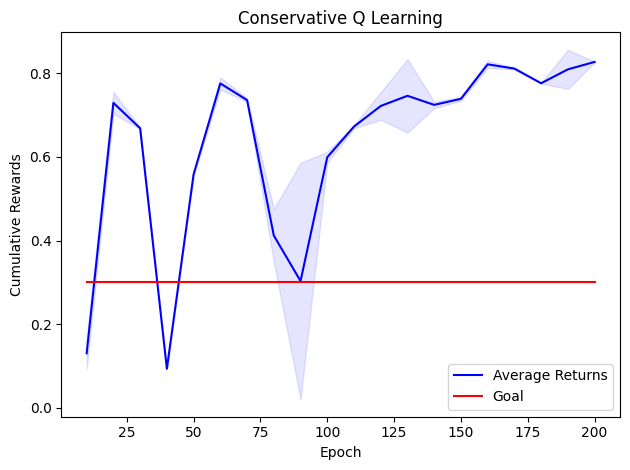

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
EPOCHS = 200
EVAL_FREQ = 10
LOAD_FROM_CKPT = False

min_rew, max_rew = return_range(dataset, 1000) #for reward normalization. Returns min/max trajectory reward 


#############################################################################################

policy_lr_schedule = CosineAnnealingLR(policy_optimizer, EPOCHS * len(sampler)) #similarly to what is done in the paper

means, stds, start_epoch = [], [], 0
if os.path.exists('cql_checkpoint.pth') and LOAD_FROM_CKPT:
    checkpoint = torch.load('cql_checkpoint.pth')

    cql_policy.load_state_dict(checkpoint['cql_policy'])
    policy_optimizer.load_state_dict(checkpoint['policy_optimizer'])
    q_critic.load_state_dict(checkpoint['q_critic'])
    q_critic_target.load_state_dict(checkpoint['q_critic_target'])
    q_optimizer.load_state_dict(checkpoint['q_optimizer'])
    
    start_epoch = checkpoint['epoch']
    means = checkpoint['means']
    stds = checkpoint['stds']
    
    print(f'Resuming run from epoch {start_epoch}')

for epoch in range(start_epoch, EPOCHS):
    total_q_loss = total_v_loss = total_policy_loss = count = 0
    policy_losses = []
    # for batch in tqdm(dataloader):
    for batch in tqdm(sampler):
        ################# Gather batch data ##################
        state = batch['state'].to(DEVICE)
        next_state = batch['next_state'].to(DEVICE)
        action = batch['action'].to(DEVICE)
        reward = einops.rearrange(batch['reward'], 'b -> b 1').to(DEVICE)
        reward = reward / (max_rew - min_rew) * 1000
        #reward = reward-1
        not_done = einops.rearrange(batch['not_done'], 'b -> b 1').to(DEVICE)
        ######################################################
        
        
        ################### Update networks ##################
        #Update Q network
        target = reward+not_done*gamma
        q_loss = optimize_phi(state,action,reward,next_state,not_done)
        
        #Update target network
        update_target()
        
        #Update policy network
        policy_loss = optimize_theta(state)
        ######################################################
        
        #Record the losses throughout the training
        total_q_loss += q_loss.item()
        total_policy_loss += policy_loss.item()
        count += 1
    
    #Evaluation step
    if (epoch + 1) % EVAL_FREQ == 0:
        rew_mean, rew_std = eval_policy(cql_policy, environment_name=ENVIRONMENT_NAME, eval_episodes=50)
        print(f'Epoch: {epoch + 1}. Q Loss: {total_q_loss / count:.4f}. P Loss: {total_policy_loss / count:.4f}. Reward: {rew_mean:.4f} +/- {rew_std:.4f}')
        means.append(rew_mean)
        stds.append(rew_std)

    # Save a checkpoint so that you can resume training if it crashes
    checkpoint = {
        'cql_policy': cql_policy.state_dict(),
        'policy_optimizer': policy_optimizer.state_dict(),
        'q_critic': q_critic.state_dict(),
        'q_critic_target': q_critic_target.state_dict(),
        'q_optimizer': q_optimizer.state_dict(),
        'epoch': epoch + 1,
        'means': means,
        'stds': stds
    }
    torch.save(checkpoint, 'cql_checkpoint.pth')

epochs = np.arange(EVAL_FREQ, EPOCHS+1, step=EVAL_FREQ)
print(epochs)
print(stds)
plot_returns(means, stds, 'Conservative Q Learning', goal=0.3, epochs=epochs)

/scratch/1036318/ipykernel_3806103/3853992630.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cql_policy.load_state_dict(torch.load('cql_checkpoint.pth')['cql_policy'])


2847.7429516773277


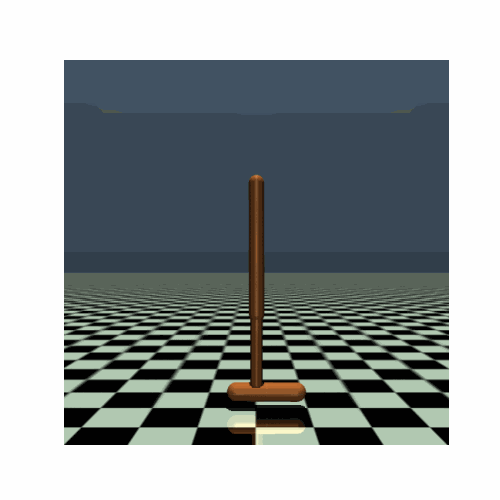

In [12]:
cql_policy.load_state_dict(torch.load('cql_checkpoint.pth')['cql_policy'])
frames, total_reward = demo_policy(cql_policy, environment_name=ENVIRONMENT_NAME, steps=1000)
print(total_reward)
gif_path = save_frames_as_gif(frames, method_name='cql')
Image(open(gif_path,'rb').read())